In [338]:
import torch
import torch.utils.data
from torch import nn
from torch.nn import functional as F
!pip install pytorch-ignite==0.4.0.dev20200404
from ignite.engine import Events, Engine
from ignite.metrics import Accuracy, Loss

import numpy as np
import sklearn.datasets

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [339]:
class Model_bilinear(nn.Module):
    def __init__(self, features, num_embeddings):
        super().__init__()
        
        self.gamma = 0.99
        self.sigma = 0.3
        
        embedding_size = 10
        
        self.fc1 = nn.Linear(2, features)
        self.fc2 = nn.Linear(features, features)
        self.fc3 = nn.Linear(features, features)
        
        self.W = nn.Parameter(torch.normal(torch.zeros(embedding_size, num_embeddings, features), 1))
        
        self.register_buffer('N', torch.ones(num_embeddings) * 20)
        self.register_buffer('m', torch.normal(torch.zeros(embedding_size, num_embeddings), 1))
        
        self.m = self.m * self.N.unsqueeze(0)

    def embed(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # i is batch, m is embedding_size, n is num_embeddings (classes)
        x = torch.einsum('ij,mnj->imn', x, self.W)
        
        return x

    def bilinear(self, z):
        embeddings = self.m / self.N.unsqueeze(0)
        
        diff = z - embeddings.unsqueeze(0)            
        y_pred = (- diff**2).mean(1).div(2 * self.sigma**2).exp()

        return y_pred

    def forward(self, x):
        z = self.embed(x)
        y_pred = self.bilinear(z)
        
        return z, y_pred

    def update_embeddings(self, x, y):
        z = self.embed(x)
        
        # normalizing value per class, assumes y is one_hot encoded
        self.N = torch.max(self.gamma * self.N + (1 - self.gamma) * y.sum(0), torch.ones_like(self.N))
        
        # compute sum of embeddings on class by class basis
        features_sum = torch.einsum('ijk,ik->jk', z, y)
        
        self.m = self.gamma * self.m + (1 - self.gamma) * features_sum

In [340]:
np.random.seed(0)
torch.manual_seed(0)

l_gradient_penalty = 0.8

# Moons
noise = 0.1
X_train, y_train = sklearn.datasets.make_blobs(n_samples=[200,200],centers=[[-1.2,0],[1.2,0]])
X_test, y_test = sklearn.datasets.make_blobs(n_samples=[200,200],centers=[[-1.2,0],[1.2,0]])

num_classes = 2
batch_size = 64

model = Model_bilinear(20, num_classes)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)


def calc_gradient_penalty(x, y_pred):
    gradients = torch.autograd.grad(
            outputs=y_pred,
            inputs=x,
            grad_outputs=torch.ones_like(y_pred),
            create_graph=True,
        )[0]


    gradients = gradients.flatten(start_dim=1)
    
    # L2 norm
    grad_norm = gradients.norm(2, dim=1)

    # Two sided penalty
    gradient_penalty = ((grad_norm - 1) ** 2).mean()
    
    # One sided penalty - down
#     gradient_penalty = F.relu(grad_norm - 1).mean()

    return gradient_penalty


def output_transform_acc(output):
    y_pred, y, x, z = output
    
    y = torch.argmax(y, dim=1)
        
    return y_pred, y


def output_transform_bce(output):
    y_pred, y, x, z = output

    return y_pred, y


def output_transform_gp(output):
    y_pred, y, x, z = output

    return x, y_pred


def step(engine, batch):
    model.train()
    optimizer.zero_grad()
    
    x, y = batch
    x.requires_grad_(True)
    
    z, y_pred = model(x)
    
    loss1 =  F.binary_cross_entropy(y_pred, y)
    loss2 = l_gradient_penalty * calc_gradient_penalty(x, y_pred)
    
    loss = loss1 + loss2
    
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        model.update_embeddings(x, y)
    
    return loss.item()


def eval_step(engine, batch):
    model.eval()

    x, y = batch

    x.requires_grad_(True)

    z, y_pred = model(x)

    return y_pred, y, x, z
    

trainer = Engine(step)
evaluator = Engine(eval_step)

metric = Accuracy(output_transform=output_transform_acc)
metric.attach(evaluator, "accuracy")

metric = Loss(F.binary_cross_entropy, output_transform=output_transform_bce)
metric.attach(evaluator, "bce")

metric = Loss(calc_gradient_penalty, output_transform=output_transform_gp)
metric.attach(evaluator, "gp")


ds_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), F.one_hot(torch.from_numpy(y_train)).float())
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True)

ds_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), F.one_hot(torch.from_numpy(y_test)).float())
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=200, shuffle=False)

@trainer.on(Events.EPOCH_COMPLETED)
def log_results(trainer):
    evaluator.run(dl_test)
    metrics = evaluator.state.metrics

    print("Test Results - Epoch: {} Acc: {:.4f} BCE: {:.2f} GP {:.2f}"
          .format(trainer.state.epoch, metrics['accuracy'], metrics['bce'], metrics['gp']))

In [341]:
trainer.run(dl_train, max_epochs=30)

Test Results - Epoch: 1 Acc: 0.8450 BCE: 1.03 GP 0.86
Test Results - Epoch: 2 Acc: 0.8650 BCE: 0.63 GP 0.70
Test Results - Epoch: 3 Acc: 0.8675 BCE: 0.60 GP 0.49
Test Results - Epoch: 4 Acc: 0.8650 BCE: 0.52 GP 0.50
Test Results - Epoch: 5 Acc: 0.8900 BCE: 0.52 GP 0.48
Test Results - Epoch: 6 Acc: 0.8850 BCE: 0.44 GP 0.48
Test Results - Epoch: 7 Acc: 0.8950 BCE: 0.50 GP 0.45
Test Results - Epoch: 8 Acc: 0.8800 BCE: 0.36 GP 0.46
Test Results - Epoch: 9 Acc: 0.8950 BCE: 0.38 GP 0.43
Test Results - Epoch: 10 Acc: 0.8775 BCE: 0.45 GP 0.36
Test Results - Epoch: 11 Acc: 0.8850 BCE: 0.41 GP 0.32
Test Results - Epoch: 12 Acc: 0.8950 BCE: 0.44 GP 0.31
Test Results - Epoch: 13 Acc: 0.8950 BCE: 0.42 GP 0.30
Test Results - Epoch: 14 Acc: 0.8925 BCE: 0.43 GP 0.31
Test Results - Epoch: 15 Acc: 0.8925 BCE: 0.41 GP 0.37
Test Results - Epoch: 16 Acc: 0.8875 BCE: 0.38 GP 0.40
Test Results - Epoch: 17 Acc: 0.9000 BCE: 0.41 GP 0.35
Test Results - Epoch: 18 Acc: 0.8925 BCE: 0.37 GP 0.36
Test Results - Epoc

State:
	iteration: 180
	epoch: 30
	epoch_length: 6
	max_epochs: 30
	output: 0.656029462814331
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: 65605364

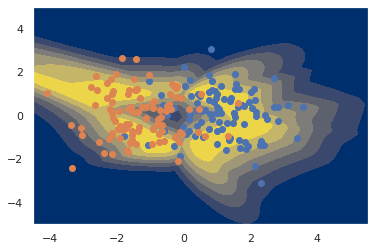

In [342]:
domain = 5
x_lin = np.linspace(-domain+0.5, domain+0.5, 100)
y_lin = np.linspace(-domain, domain, 100)

xx, yy = np.meshgrid(x_lin, y_lin)

X_grid = np.column_stack([xx.flatten(), yy.flatten()])

X_vis, y_vis = sklearn.datasets.make_blobs(n_samples=[100,100],centers=[[-1.2,0],[1.2,0]])
mask = y_vis.astype(np.bool)

with torch.no_grad():
    output = model(torch.from_numpy(X_grid).float())[1]
    confidence = output.max(1)[0].numpy()


z = confidence.reshape(xx.shape)

plt.figure()
plt.contourf(x_lin, y_lin, z, cmap='cividis')

plt.scatter(X_vis[mask,0], X_vis[mask,1])
plt.scatter(X_vis[~mask,0], X_vis[~mask,1])